# Pokemon GAN Training Notebook

## **Import libraries**

In [4]:
import sys
sys.path.append('../sources')

In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PokemonGensDataset
from ACGAN import AuxGAN
import utils as ut
import os
import variable as var
import cuda_monitoring as cuda_mon
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
import torchvision.utils as vutils

In [3]:
cuda_mon.get_tensor_info()
cuda_mon.get_gpu_memory_info()

/home/benoit/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:144: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


total    : 7.77 GB
free     : 6.89 GB
used     : 909.25 MB	(12.9%)


## **Load DATASET**

In [6]:
resume_training = True
train_number = 28
gan_id = f"acgan_cp_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 64
label_name = 'Type_1'
normalize_input = 'min_max_scale'

print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [7]:
dset = PokemonGensDataset(label_name=label_name, greyscale=greyscale, normalize=normalize_input,
                          resize=[resize_image_dim, resize_image_dim], 
                          gens_to_remove=("gen8", ))
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f'dataset: {len(dset)} images')

dataset: 5960 images


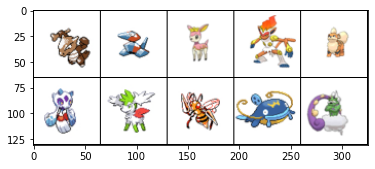

In [8]:
images, labels = next(iter(dloader))
ut.show_images_grid(images)

apply weights on inputs based on element wise auxiliary own class probability prediction
to do: in the generator loss function, multiply each sample-loss-value (torch.NLLLoss) value by its own class probability given by the discriminator. 


## **GAN Component**

In [9]:
gen_lr = 1e-4
disc_lr = 1e-4
beta1 = .9
beta2 = .999
betas = {'1': beta1, '2': beta2}
n_channel = 1 if greyscale else 3
n_feature = 32
z_dim = 100
n_classes = len(dset.label_id_to_label_name)
use_inception = False
embedding = True
label_smoothing = False

    
params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': gen_lr,
                  'betas': betas,
                  'embedding': embedding},
          'disc': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': disc_lr,
                   'betas': betas},
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'n_classes': n_classes,
          'dataset': dset.describe(),
          'batch_size': batch_size,
          'label_smoothing': label_smoothing,
          'use_inception': use_inception
         }

## **GAN INIT AND TRAINING**

In [10]:
gan = AuxGAN(params)
checkpoint_path = os.path.join(var.PROJECT_DIR, f'data/models/{gan_id}.pth')
if os.path.exists(checkpoint_path):
    print('RESUMING TRAINING...')
    gan.load_model(checkpoint_path)
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

NEW TRAINING...
id: acgan_cp_pokemon_train_28


In [11]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [14]:
gan.train(n_epoch=150, dataloader=dloader, gan_id=gan_id)

100%|██████████| 150/150 [47:11<00:00, 18.88s/it]


## **RESULT VIZUALIZATION**

class: Grass


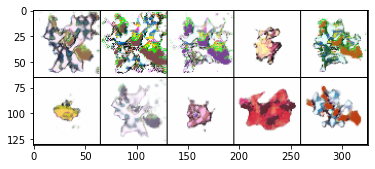

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Fire


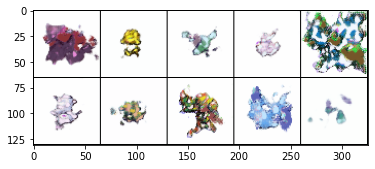

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Water


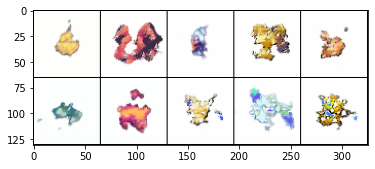

fake/real precision: 1.0
auxiliary precision: 0.1
--------------------------------------------------------------------------
class: Bug


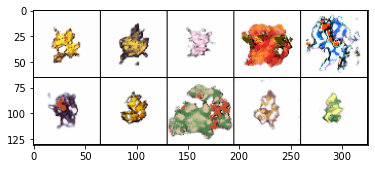

fake/real precision: 1.0
auxiliary precision: 0.1
--------------------------------------------------------------------------
class: Normal


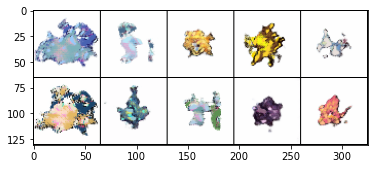

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Poison


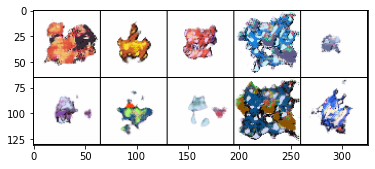

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Electric


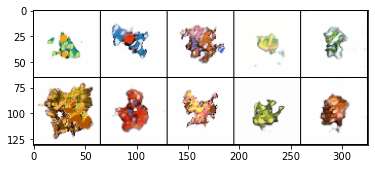

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Ground


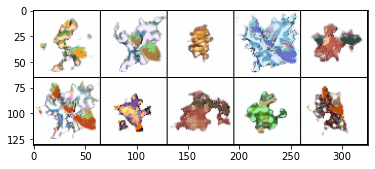

fake/real precision: 1.0
auxiliary precision: 0.2
--------------------------------------------------------------------------
class: Fairy


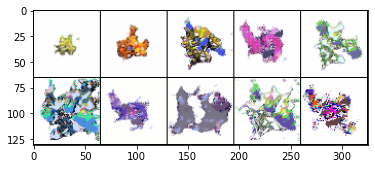

fake/real precision: 0.9
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Fighting


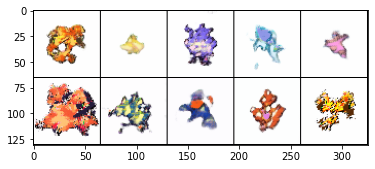

fake/real precision: 0.9
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Psychic


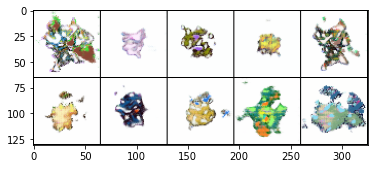

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Rock


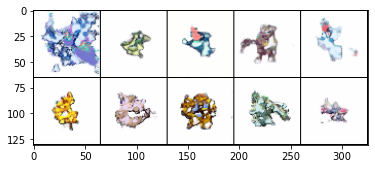

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Ghost


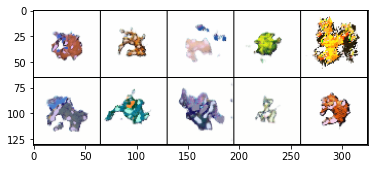

fake/real precision: 0.9
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Ice


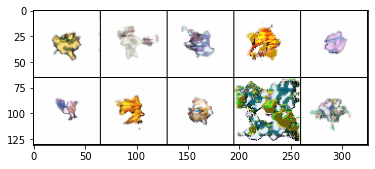

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Dragon


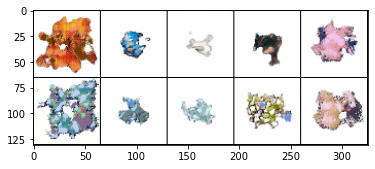

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Dark


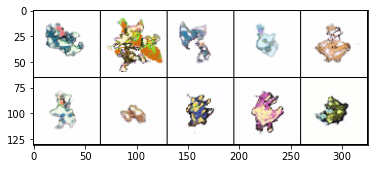

fake/real precision: 1.0
auxiliary precision: 0.5
--------------------------------------------------------------------------
class: Steel


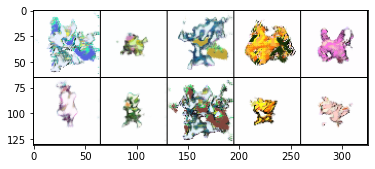

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: Flying


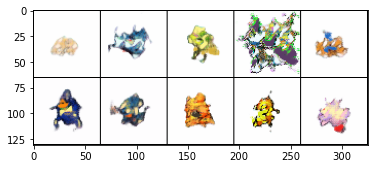

fake/real precision: 0.9
auxiliary precision: 0.0
--------------------------------------------------------------------------


In [15]:
for label_id, label_name in dset.label_id_to_label_name.items():
    print(f"class: {dset.label_id_to_label_name[label_id]}")
    with torch.no_grad():
        fakes, classes = gan.generate_fake(10, train=False, being_class=label_id)
        adv, aux = gan.discriminator(fakes)
        adv_label = adv < .5
        aux_label = torch.argmax(aux, dim=1) == classes.cuda()

    ut.show_images_grid(fakes)
    print(f"fake/real precision: {round((adv_label.sum()/ len(adv_label)).item(), 3)}")
    print(f"auxiliary precision: {round((aux_label.sum()/ len(aux_label)).item(), 3)}")
    print("--------------------------------------------------------------------------")

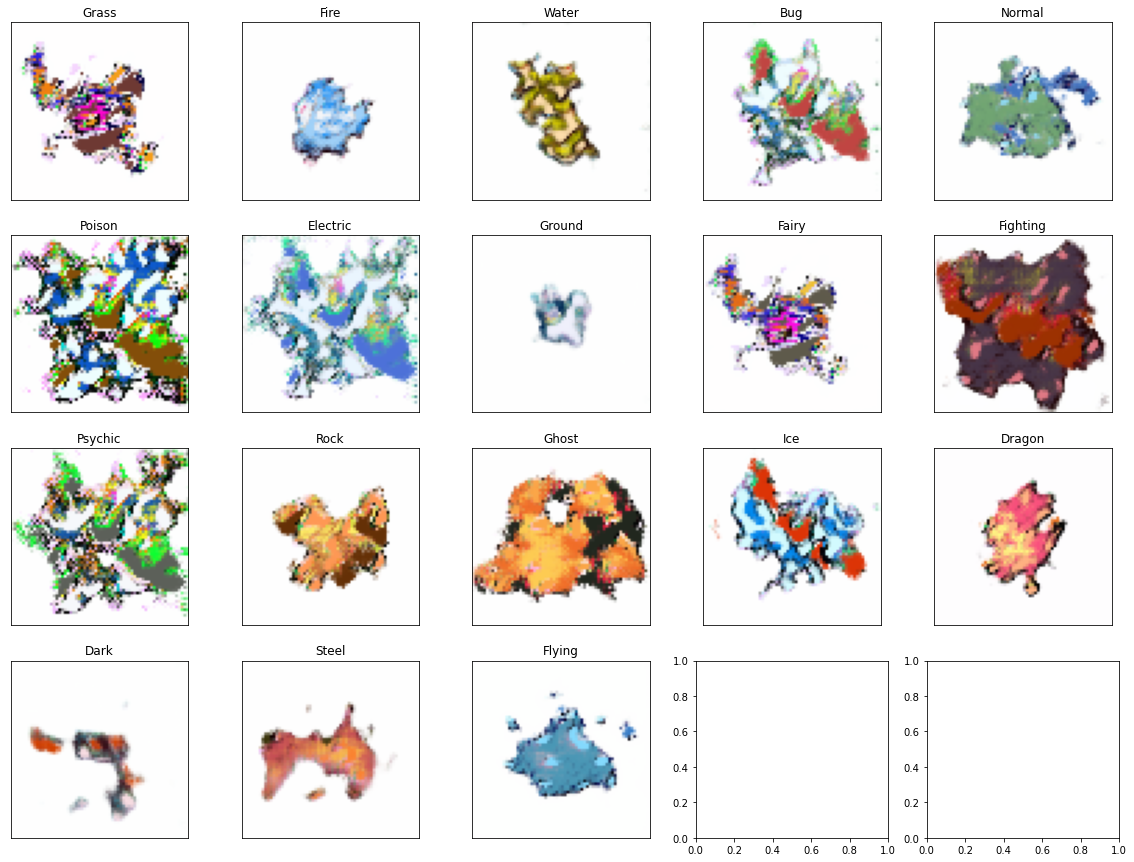

In [39]:
being_class = 9
n = 2
noise = torch.ones(n, z_dim, 1, 1, device=var.device) 
noise = gan.get_random_noise(n)
n_label = len(dset.label_id_to_label_name)
n_label_per_row = 4
n_label_per_col = (n_label // n_label_per_row) + 1
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=n_label_per_row, 
                                 ncols=n_label_per_col)
for idx, (label_id, label_name) in enumerate(dset.label_id_to_label_name.items()):
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * label_id
        gan.generator.eval()
        fakes = gan.generator.forward(noise, classes)
        
    i = idx // n_label_per_col
    j = idx % n_label_per_col
    with warnings.catch_warnings():
        fakes_grid = ut.images_grid(fakes[0], tensorboard=False)
        axes[i][j].imshow(fakes_grid)
    axes[i][j].set_title(f"{dset.label_id_to_label_name[label_id]}")
    axes[i][j].xaxis.set_visible(False)
    axes[i][j].yaxis.set_visible(False)
    

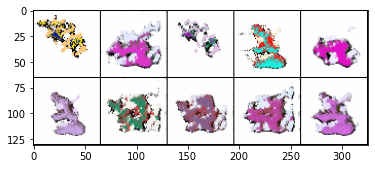

serpentine
with_fins
head_only
bipedal_tailed
head_only
with_fins
multiple_bodies
head_only
multiple_bodies
wings


In [95]:
fake, labels = gan.generate_fake(10, train=False)
ut.show_images_grid(fake)
for label in labels:
    print(dset.label_id_to_label_name[label.item()])

In [301]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    max_max_grad = 0.0
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            max_grad = p.grad.abs().max()
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(max_grad)
            max_max_grad = max_grad.item() if max_grad.item() > max_max_grad else max_max_grad
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=.1) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    print(max_grads)

[tensor(5.6651, device='cuda:0'), tensor(37.1417, device='cuda:0'), tensor(1.7497, device='cuda:0'), tensor(30.0315, device='cuda:0'), tensor(0.9447, device='cuda:0'), tensor(10.2452, device='cuda:0'), tensor(0.7397, device='cuda:0'), tensor(5.7435, device='cuda:0'), tensor(1.0466, device='cuda:0'), tensor(3.3919, device='cuda:0'), tensor(0.4834, device='cuda:0'), tensor(2.8198, device='cuda:0'), tensor(0.4163, device='cuda:0'), tensor(4.1677, device='cuda:0'), tensor(0.4484, device='cuda:0'), tensor(1.1201, device='cuda:0'), tensor(0.2270, device='cuda:0'), tensor(1.3180, device='cuda:0'), tensor(0.2039, device='cuda:0'), tensor(3.9053, device='cuda:0'), tensor(0.7421, device='cuda:0'), tensor(0.1336, device='cuda:0'), tensor(0.7735, device='cuda:0'), tensor(0.3978, device='cuda:0'), tensor(4.6653, device='cuda:0'), tensor(0.7022, device='cuda:0'), tensor(0.1534, device='cuda:0'), tensor(0.6080, device='cuda:0'), tensor(0.2281, device='cuda:0'), tensor(1.1207, device='cuda:0'), tensor

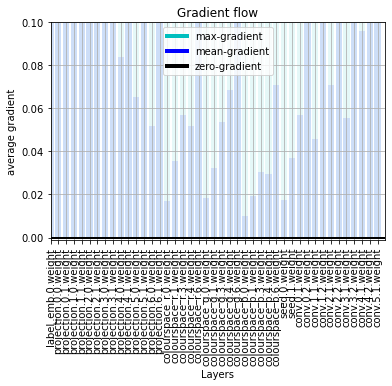

In [302]:
plot_grad_flow(gan.generator.named_parameters())

In [144]:
torch.mul(torch.randn((16, 100)).view(16, 100, 1, 1), torch.randn((16, 100, 1, 1))).shape

torch.Size([16, 100, 1, 1])

In [125]:
fake, fake_classes = gan.generate_fake(batch_size)

fake_adv, fake_aux = gan.discriminator(fake)
torch.gather(fake_aux, 1, fake_classes.unsqueeze(1)).shape

torch.Size([128, 1])

In [126]:
fake_aux.shape

torch.Size([128, 10])

In [127]:
fake_classes.unsqueeze(1).shape

torch.Size([128, 1])

In [49]:
gan.generator.label_emb(torch.randint(10, (128, 1), device=var.device)).shape

torch.Size([128, 1, 100])

In [37]:
25*180/12

375.0